SCHEDULE

In [20]:
import numpy as np
import simpy
from scipy.stats import expon, norm, gamma
import matplotlib.pyplot as plt


# Working day: from 8:00 (0 in simulation time) to 17:00 (540 in simulation time)
DAY_LENGTH = 540   # minutes from 8:00 to 17:00
START_TIME = 0     # start of the day (8:00)
END_TIME = DAY_LENGTH  # end of the day (17:00 = 540 minutes after 8:00)
NUM_DAYS = 100     # number of days to simulate

# Patient type 1 parameters
mean_iat_type1 = 33.0  # exponential mean inter-arrival time (minutes)
mean_scan_type1 = 26.0
var_scan_type1 = 36
std_scan_type1 = 6

# Patient type 2 parameters
mean_iat_type2 = 50.0  # normal mean inter-arrival time
var_iat_type2 = 5.0
std_iat_type2 = np.sqrt(var_iat_type2)
mean_scan_type2 = 38.0
var_scan_type2 = 2.0
std_scan_type2 = np.sqrt(var_scan_type2)

# Derived parameters or distributions:
def iat_type1():
    return expon(scale=mean_iat_type1).rvs()

def scan_type1():
    # Normal duration
    return norm(loc=mean_scan_type1, scale=std_scan_type1).rvs()

def iat_type2():
    return norm(loc=mean_iat_type2, scale=std_iat_type2).rvs()

def scan_type2():
    
    shape = mean_scan_type2**2 / var_scan_type2
    scale = var_scan_type2 / mean_scan_type2
    return gamma(a=shape, scale=scale).rvs()

# Fixed time slots to decide (to be experimented with):
slot_length_type1 = 30.0
slot_length_type2 = 40.0

# Number of MRI machines (both can handle any patient type)
NUM_MACHINES = 2

# -------------------------
# Simulation Model
# -------------------------

class Patient:
    def __init__(self, patient_id, patient_type, arrival_day, arrival_time):
        self.id = patient_id
        self.type = patient_type
        self.arrival_day = arrival_day
        self.arrival_time = arrival_time
        self.scheduled_day = None
        self.scheduled_starttime = None  # Scheduled start time in minutes after 8:00
        self.end_scan_time = None
        self.assigned_machine = None
        self.scan_duration = None
        self.actual_starttime = None
        self.actual_endtime = None

def run_simulation(slot_length_type1, slot_length_type2):
    """
    Now we have two machines that can both scan any type of patient.
    For each new patient arrival (type1 or type2), we schedule it on
    whichever machine can start the patient *earliest* on a new day.
    """

    env = simpy.Environment()
    patients = []
    patient_id = 0  # Unique identifier for each patient

    # next_available_time[m] = the absolute simulation time
    #                         (in minutes from time 0) when machine m is free.
    # Initialize them to the end of day 0, so effectively we start scheduling from day 1.
    next_available_time = [DAY_LENGTH for _ in range(NUM_MACHINES)]

    # next_earliest_scantime[m] = earliest possible actual start time within a single day
    # (the 0-540 window for that day). We reset it every time we move to a new day on machine m.
    next_earliest_scantime = [0 for _ in range(NUM_MACHINES)]

    # last_scheduled_day[m] = the last day on which we scheduled a patient on machine m
    last_scheduled_day = [None for _ in range(NUM_MACHINES)]

    def find_earliest_machine(day, slot_length):
       
        candidate_times = []
        for m in range(NUM_MACHINES):
            na_time = next_available_time[m]

            # If the machine's next available day is the same as the arrival day,
            # force scheduling on the next day (day+1).
            if int(na_time // DAY_LENGTH) == day:
                na_time = (day + 1) * DAY_LENGTH

            candidate_times.append((m, na_time))

        # Among the candidate times, pick the earliest
        machine_id, earliest_time = min(candidate_times, key=lambda x: x[1])

       
        return machine_id, earliest_time

    # ------------------------------------------------------------------
    # Scheduling a new patient on the chosen machine
    # ------------------------------------------------------------------
    def schedule_patient_on_machine(patient, machine_id, scheduled_time, slot_length):
        
        nonlocal next_available_time, next_earliest_scantime, last_scheduled_day

        
        next_available_time[machine_id] = scheduled_time + slot_length

        
        overflow = next_available_time[machine_id] % DAY_LENGTH
        if overflow > (DAY_LENGTH - slot_length):
            # We exceed the day limit, so push to the next day boundary
            next_available_time[machine_id] += (DAY_LENGTH - overflow)

        # Convert the absolute scheduled_time to day + minutes-of-day
        patient.scheduled_day = int(scheduled_time // DAY_LENGTH)
        patient.scheduled_starttime = scheduled_time % DAY_LENGTH

        # If we are on a different scheduled_day than the last patient on this machine,
        # reset next_earliest_scantime[machine_id].
        if last_scheduled_day[machine_id] is None or patient.scheduled_day != last_scheduled_day[machine_id]:
            next_earliest_scantime[machine_id] = 0
            last_scheduled_day[machine_id] = patient.scheduled_day

        # Actual start time is the max of the scheduled start time and the next earliest
        # scanning start time within that day (so you don't overlap).
        patient.actual_starttime = max(patient.scheduled_starttime, next_earliest_scantime[machine_id])
        patient.actual_endtime = patient.actual_starttime + patient.scan_duration

        # Update next_earliest_scantime for that machine
        next_earliest_scantime[machine_id] = patient.actual_endtime

        patient.assigned_machine = f"Machine_{machine_id}"

    # ------------------------------------------------------------------
    # Patient generators
    # ------------------------------------------------------------------
    def patient_generator_type1(env, patients):
        nonlocal patient_id
        while True:
            # Wait for inter-arrival time
            inter_arrival = iat_type1()
            yield env.timeout(inter_arrival)

            # Calculate arrival day and time
            total_minutes = env.now
            day = int(total_minutes // DAY_LENGTH)
            time_of_day = total_minutes % DAY_LENGTH

            if day >= NUM_DAYS:
                break  # Stop generating after NUM_DAYS

            # Create the patient
            patient = Patient(
                patient_id=patient_id,
                patient_type=1,
                arrival_day=day,
                arrival_time=time_of_day
            )
            patient_id += 1

            # Determine the scan duration
            patient.scan_duration = scan_type1()

            # Find which machine can schedule it soonest on day+1 or later
            machine_id, earliest_time = find_earliest_machine(day, slot_length_type1)
            # Schedule the patient
            schedule_patient_on_machine(patient, machine_id, earliest_time, slot_length_type1)

            patients.append(patient)

    def patient_generator_type2(env, patients):
        nonlocal patient_id
        while True:
            # Wait for inter-arrival time
            inter_arrival = max(iat_type2(), 1.0)
            yield env.timeout(inter_arrival)

            # Calculate arrival day and time
            total_minutes = env.now
            day = int(total_minutes // DAY_LENGTH)
            time_of_day = total_minutes % DAY_LENGTH

            if day >= NUM_DAYS:
                break  # Stop generating after NUM_DAYS

            # Create the patient
            patient = Patient(
                patient_id=patient_id,
                patient_type=2,
                arrival_day=day,
                arrival_time=time_of_day
            )
            patient_id += 1

            # Determine the scan duration
            patient.scan_duration = scan_type2()

            # Find which machine can schedule it soonest on day+1 or later
            machine_id, earliest_time = find_earliest_machine(day, slot_length_type2)
            # Schedule the patient
            schedule_patient_on_machine(patient, machine_id, earliest_time, slot_length_type2)

            patients.append(patient)

    # Start patient generators
    env.process(patient_generator_type1(env, patients))
    env.process(patient_generator_type2(env, patients))

    # Run the simulation
    # Add 30 days buffer to let all scheduled patients finish
    env.run(until=(NUM_DAYS + 30) * DAY_LENGTH)

    return patients

patients = run_simulation(slot_length_type1, slot_length_type2)



FUNCTIONS

In [27]:
def calculate_average_wait_time_all(patients):
    
    if not patients:
        return 0.0
    
    total_wait = 0.0
    for p in patients:
        wait_time = max(0, p.actual_starttime - p.scheduled_starttime)
        total_wait += wait_time
    
    return total_wait / len(patients)



def calculate_average_wait_time_to_appointment_in_days(patients):
    
    if not patients:
        return 0.0
    
    total_wait = 0.0
    for p in patients:
        wait_time = max(0, p.scheduled_day - p.arrival_day)
        total_wait += wait_time
    
    return total_wait / len(patients)



from collections import defaultdict

def calculate_average_overtime(patients):
    """
    Calculates the average overtime across all days.
    
    - Overtime for one day is:
        max(0, (latest actual end time of any patient) - 540).
      If the latest actual end time is <= 540, overtime is 0.
      
    - Returns:
        The average daily overtime (float).
    """
    # Dictionary to track the latest actual_endtime per day
    day_latest_end_time = defaultdict(float)

    # 1. Find the max actual_endtime per day across both machines
    for patient in patients:
        # We'll only consider patients who have a valid scheduled_day
        # and actual_endtime
        if patient.scheduled_day is not None and patient.actual_endtime is not None:
            current_day = patient.scheduled_day
            day_latest_end_time[current_day] = max(
                day_latest_end_time[current_day],
                patient.actual_endtime
            )

    # 2. Calculate daily overtime for each day
    daily_overtimes = []
    for day, last_end_time in day_latest_end_time.items():
        # Overtime is (last_end_time - 540) if last_end_time > 540
        daily_overtimes.append(max(0, last_end_time - 540))

    # 3. Calculate the average overtime across all days
    if not daily_overtimes:
        return 0.0  # If there are no patients or no valid times, return 0
    return sum(daily_overtimes) / len(daily_overtimes)


def get_system_utilization_all(patients, num_machines=2):
    
    if not patients:
        return 0.0
    
    # Sum of scan durations for ALL patients
    total_scan_duration = sum(p.scan_duration for p in patients if p.scan_duration)

    # Distinct scheduled days used by ANY patient
    days_used = {p.scheduled_day for p in patients if p.scheduled_day is not None}

    # Total time available = (# distinct days) * 540 * num_machines
    total_time_available = len(days_used) * 540 * num_machines
    
    if total_time_available == 0:
        return 0.0
    
    utilization = total_scan_duration / total_time_available
    return utilization




Slot Length Type1: 100%|████████████████████████| 36/36 [47:15<00:00, 78.77s/it]


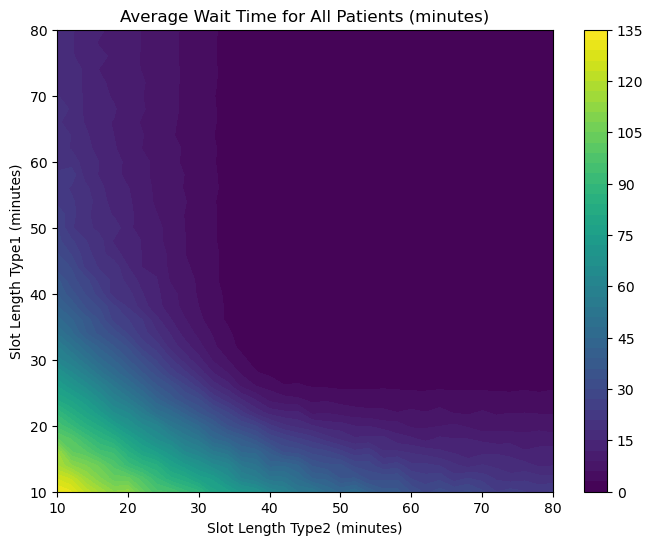

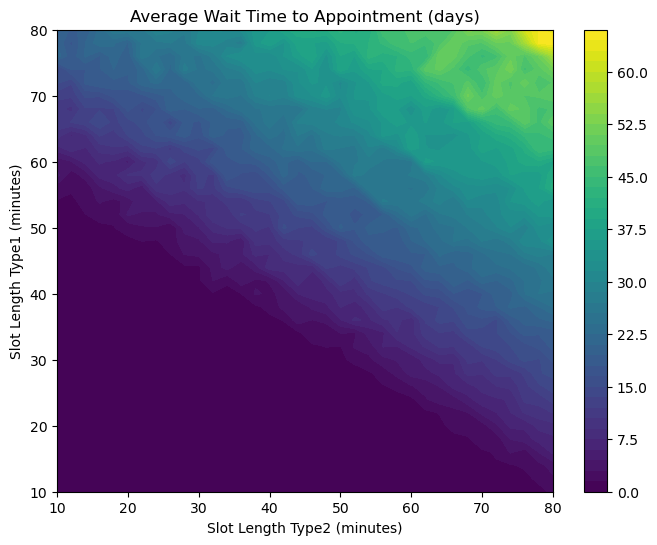

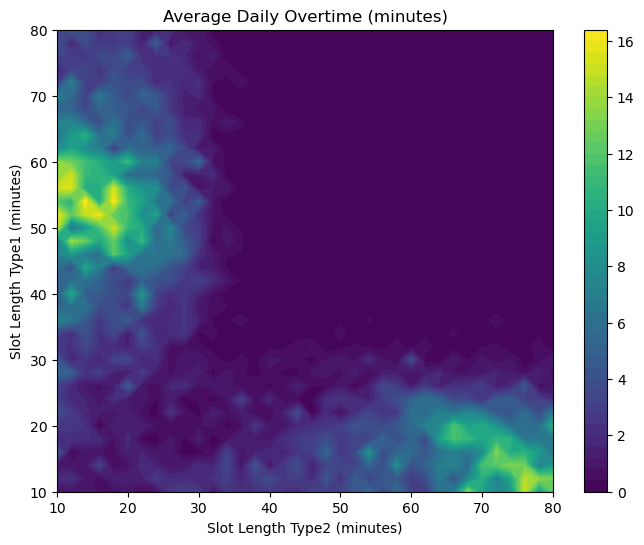

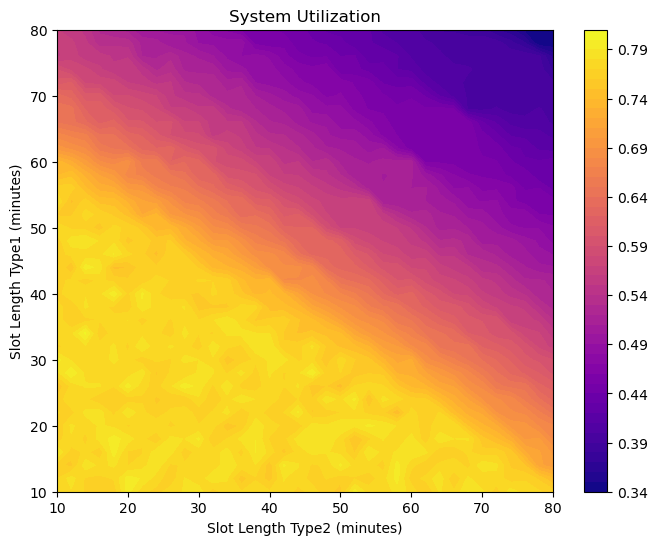

In [33]:
from tqdm import tqdm  # For progress bar

slot_lengths = range(10, 81, 2)
slot_length_type1_list = list(slot_lengths)
slot_length_type2_list = list(slot_lengths)

# Initialize matrices to store performance metrics
avg_wait_all_matrix = np.zeros((len(slot_length_type1_list), len(slot_length_type2_list)))
avg_wait_days_matrix = np.zeros((len(slot_length_type1_list), len(slot_length_type2_list)))
avg_overtime_matrix = np.zeros((len(slot_length_type1_list), len(slot_length_type2_list)))
utilization_matrix = np.zeros((len(slot_length_type1_list), len(slot_length_type2_list)))

# Iterate over all combinations with progress bar
for i, slot1 in enumerate(tqdm(slot_length_type1_list, desc="Slot Length Type1")):
    for j, slot2 in enumerate(slot_length_type2_list):
        patients = run_simulation(slot1, slot2)
        
        # Calculate performance metrics
        avg_wait_all = calculate_average_wait_time_all(patients)
        avg_wait_days = calculate_average_wait_time_to_appointment_in_days(patients)
        avg_overtime = calculate_average_overtime(patients)
        utilization = get_system_utilization_all(patients, num_machines=2)
        
        # Store in matrices
        avg_wait_all_matrix[i, j] = avg_wait_all
        avg_wait_days_matrix[i, j] = avg_wait_days
        avg_overtime_matrix[i, j] = avg_overtime
        utilization_matrix[i, j] = utilization

# Create meshgrid for plotting
X, Y = np.meshgrid(slot_length_type2_list, slot_length_type1_list)

# Define a helper function to create heatmaps
def plot_heatmap(X, Y, Z, title, xlabel, ylabel, cmap='viridis'):
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, Z, cmap=cmap, levels=50)
    plt.colorbar(cp)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot Average Wait Time for All Patients
plot_heatmap(
    X, Y, avg_wait_all_matrix,
    title='Average Wait Time for All Patients (minutes)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot Average Wait Time to Appointment in Days
plot_heatmap(
    X, Y, avg_wait_days_matrix,
    title='Average Wait Time to Appointment (days)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot Average Overtime
plot_heatmap(
    X, Y, avg_overtime_matrix,
    title='Average Daily Overtime (minutes)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot System Utilization
plot_heatmap(
    X, Y, utilization_matrix,
    title='System Utilization',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)',
    cmap='plasma'
)

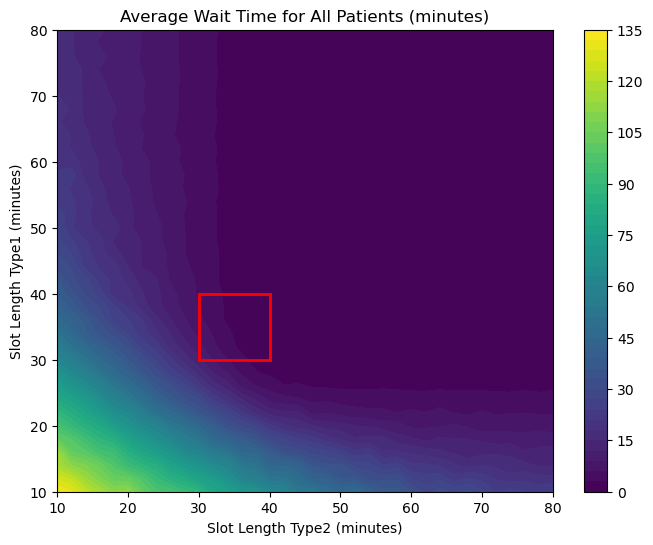

NameError: name 'ax' is not defined

In [40]:
# Define a helper function to create heatmaps
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # Import patches for drawing shapes

def plot_heatmap(X, Y, Z, title, xlabel, ylabel, cmap='viridis'):
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, Z, cmap=cmap, levels=50)
    plt.colorbar(cp)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Define the square's properties
    lower_left_corner = (30, 30)  # (x, y) coordinates
    side_length = 10  # Length of the square's sides
    
    # Create a rectangle patch
    square = patches.Rectangle(
        lower_left_corner,  # (x,y)
        side_length,        # width
        side_length,        # height
        linewidth=2,        # border thickness
        edgecolor='red',    # border color
        facecolor='none'    # no fill
    )
    
    # Add the rectangle to the current axes
    plt.gca().add_patch(square)
    
    plt.show()

    



# Plot Average Wait Time for All Patients
plot_heatmap(
    X, Y, avg_wait_all_matrix,
    title='Average Wait Time for All Patients (minutes)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot Average Wait Time to Appointment in Days
plot_heatmap(
    X, Y, avg_wait_days_matrix,
    title='Average Wait Time to Appointment (days)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot Average Overtime
plot_heatmap(
    X, Y, avg_overtime_matrix,
    title='Average Daily Overtime (minutes)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot System Utilization
plot_heatmap(
    X, Y, utilization_matrix,
    title='System Utilization',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)',
    cmap='plasma'
)


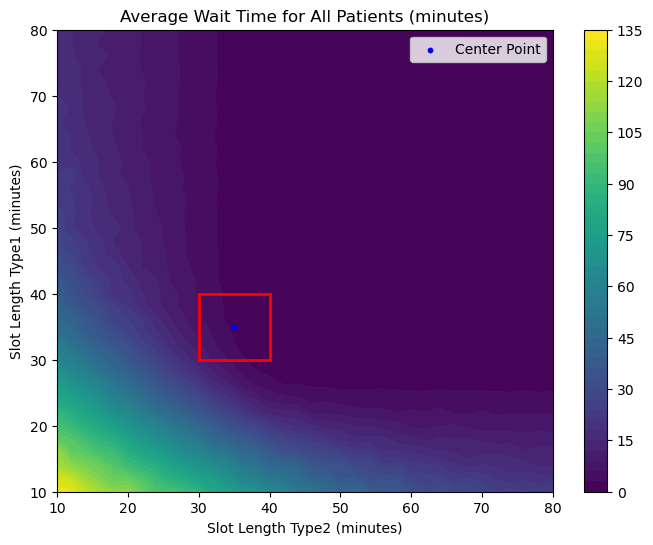

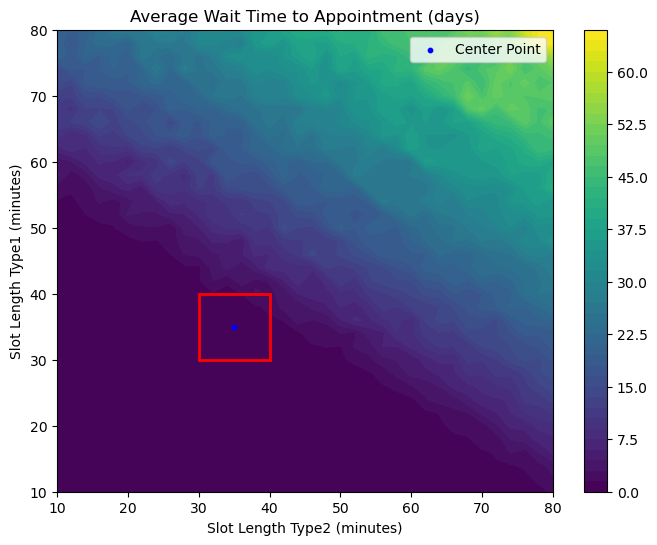

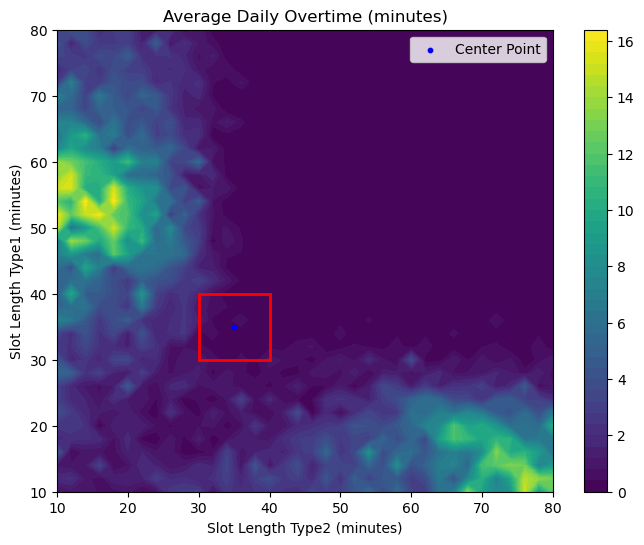

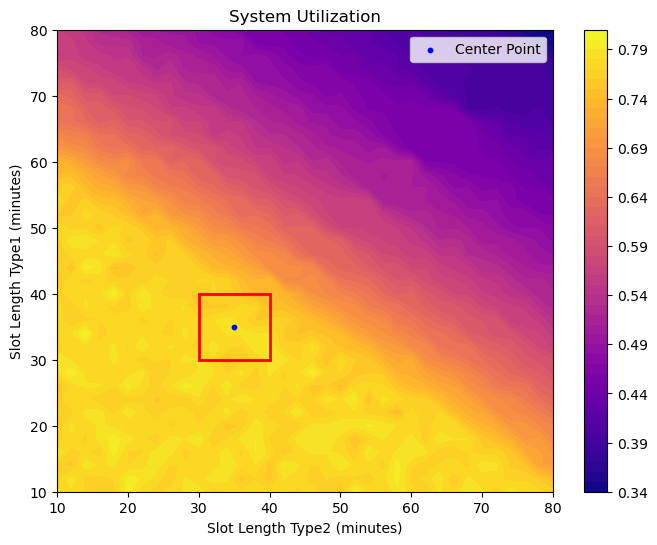

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # For drawing shapes

def plot_heatmap(X, Y, Z, title, xlabel, ylabel, cmap='viridis'):
    
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, Z, cmap=cmap, levels=50)
    plt.colorbar(cp)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Define the square's properties
    lower_left_corner = (30, 30)  # (x, y) coordinates
    side_length = 10              # Length of the square's sides
    
    # Create a rectangle patch (the square)
    square = patches.Rectangle(
        lower_left_corner,  # (x,y)
        side_length,        # width
        side_length,        # height
        linewidth=2,        # Border thickness
        edgecolor='red',    # Border color
        facecolor='none'    # No fill
    )
    
    # Add the square to the current axes
    ax = plt.gca()
    ax.add_patch(square)
    
    # Define the dot's properties
    dot_x, dot_y = 35, 35  # Coordinates for the dot
    
    # Plot the dot
    ax.scatter(dot_x, dot_y, color='blue', s=10, marker='o', zorder=5, label='Center Point')
    
    # Optionally, add a legend to identify the dot
    ax.legend(loc='upper right')
    
    plt.show()


# Plot Average Wait Time for All Patients
plot_heatmap(
    X, Y, avg_wait_all_matrix,
    title='Average Wait Time for All Patients (minutes)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot Average Wait Time to Appointment in Days
plot_heatmap(
    X, Y, avg_wait_days_matrix,
    title='Average Wait Time to Appointment (days)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot Average Overtime
plot_heatmap(
    X, Y, avg_overtime_matrix,
    title='Average Daily Overtime (minutes)',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)'
)

# Plot System Utilization
plot_heatmap(
    X, Y, utilization_matrix,
    title='System Utilization',
    xlabel='Slot Length Type2 (minutes)',
    ylabel='Slot Length Type1 (minutes)',
    cmap='plasma'
)


In [54]:
from tqdm import tqdm  # For progress bar

slot_lengths = range(30, 40, 1)
slot_length_type1_list = list(slot_lengths)
slot_length_type2_list = list(slot_lengths)

# Initialize matrices to store performance metrics
avg_wait_all_matrix = np.zeros((len(slot_length_type1_list), len(slot_length_type2_list)))
avg_wait_days_matrix = np.zeros((len(slot_length_type1_list), len(slot_length_type2_list)))
avg_overtime_matrix = np.zeros((len(slot_length_type1_list), len(slot_length_type2_list)))
utilization_matrix = np.zeros((len(slot_length_type1_list), len(slot_length_type2_list)))

# Iterate over all combinations with progress bar
for i, slot1 in enumerate(tqdm(slot_length_type1_list, desc="Slot Length Type1")):
    for j, slot2 in enumerate(slot_length_type2_list):
        patients = run_simulation(slot1, slot2)
        
        # Calculate performance metrics
        avg_wait_all = calculate_average_wait_time_all(patients)
        avg_wait_days = calculate_average_wait_time_to_appointment_in_days(patients)
        avg_overtime = calculate_average_overtime(patients)
        utilization = get_system_utilization_all(patients, num_machines=2)
        
        # Store in matrices
        avg_wait_all_matrix[i, j] = avg_wait_all
        avg_wait_days_matrix[i, j] = avg_wait_days
        avg_overtime_matrix[i, j] = avg_overtime
        utilization_matrix[i, j] = utilization

# Create meshgrid for plotting
X, Y = np.meshgrid(slot_length_type2_list, slot_length_type1_list)

Slot Length Type1: 100%|████████████████████████| 10/10 [01:39<00:00,  9.95s/it]


In [55]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Define the slot lengths
slot_length_type1_list = list(range(30, 40, 1))  # [30, 32, 34, 36, 38]
slot_length_type2_list = list(range(30, 40, 1))  # [30, 32, 34, 36, 38]

# Create DataFrames for each metric
df_avg_wait_all = pd.DataFrame(
    avg_wait_all_matrix,
    index=slot_length_type1_list,
    columns=slot_length_type2_list
)

df_avg_wait_days = pd.DataFrame(
    avg_wait_days_matrix,
    index=slot_length_type1_list,
    columns=slot_length_type2_list
)

df_avg_overtime = pd.DataFrame(
    avg_overtime_matrix,
    index=slot_length_type1_list,
    columns=slot_length_type2_list
)

df_utilization = pd.DataFrame(
    utilization_matrix,
    index=slot_length_type1_list,
    columns=slot_length_type2_list
)

print("Average Wait Time for All Patients (minutes):")
print(df_avg_wait_all)
print("\nAverage Wait Time to Appointment (days):")
print(df_avg_wait_days)
print("\nAverage Overtime (minutes):")
print(df_avg_overtime)
print("\nSystem Utilization (%):")
print(df_utilization)


Average Wait Time for All Patients (minutes):
           30         31        32        33        34        35        36  \
30  12.758339  11.058122  9.720574  7.551886  5.592982  4.316799  3.365386   
31  11.370002   9.363293  7.921311  5.747753  5.275246  3.771818  2.840882   
32  10.443802   7.843866  7.067451  5.435869  3.889447  3.458825  2.153716   
33   8.026724   7.194943  6.177114  4.703376  3.552683  2.820285  1.851369   
34   7.611036   5.972796  5.083386  4.263560  3.456393  2.435781  1.774280   
35   7.172257   6.615561  5.085653  3.722236  2.895436  2.235225  1.454439   
36   7.016099   6.022687  4.491041  3.713129  2.775727  2.071509  1.422484   
37   6.185421   5.439592  4.304623  3.435840  2.518885  2.026156  1.352354   
38   6.100981   4.800520  4.231451  3.198660  2.471732  1.745853  1.355232   
39   6.161516   4.537983  3.991902  3.313261  2.308240  1.805890  1.140629   

          37        38        39  
30  2.372921  1.533575  1.220613  
31  1.743873  1.088517  0